# Explore here

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle

In [2]:
df = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv')
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
# Convertir columna date a datetime
df['date'] = pd.to_datetime(df['date'])

# Ordenarla por fecha
df = df.sort_values('date')

# Establecer la fecha como índice
df = df.set_index('date')

df

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


### Análisis de unas serie temporal

In [5]:
# Tensor
df.index.to_series().diff().mode()

0   1 days
Name: date, dtype: timedelta64[ns]

Gracias a esto sabemos que la unidad de tiempo mínima para la cual hay datos es 1 día.

In [ ]:
# Reindexar por día y eliminar las horas
df = df.asfreq('D', normalize = True)

df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


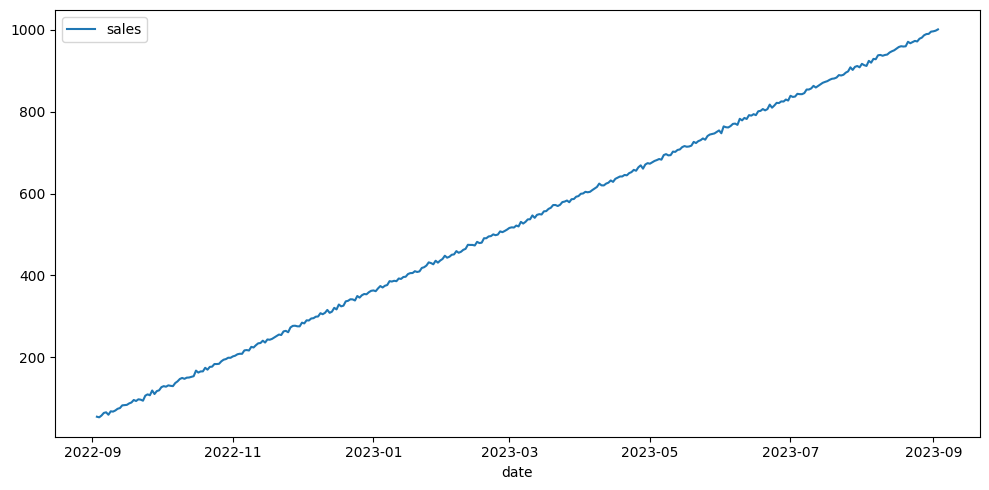

In [8]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df)

plt.tight_layout()

plt.show()

En este gráfico se observa que la tendencia es ascendiente.

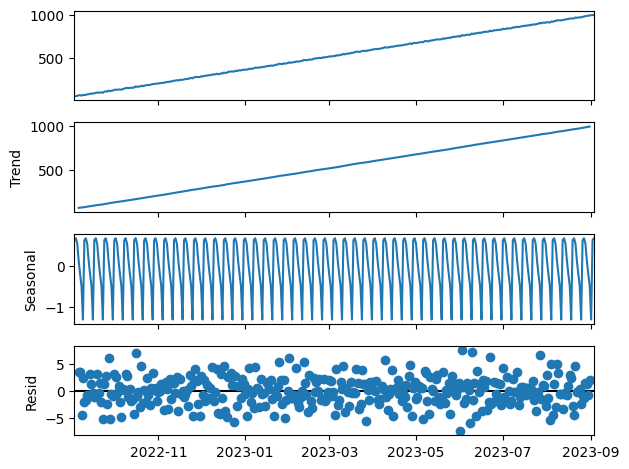

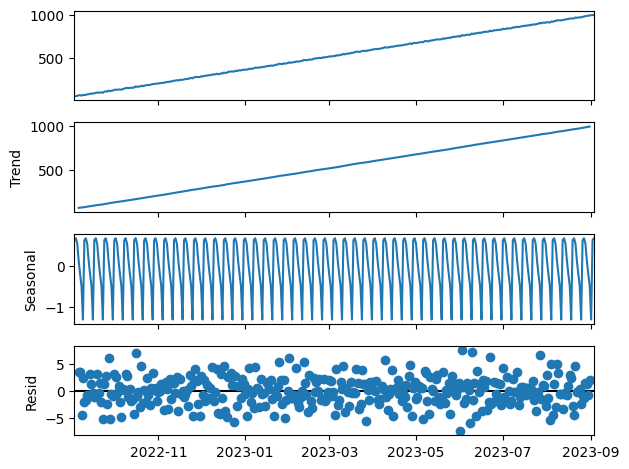

In [10]:
# Descomponer la serie temporal
decomposition = seasonal_decompose(df, period=7)
decomposition.plot()

#### Análisis de la tendencia

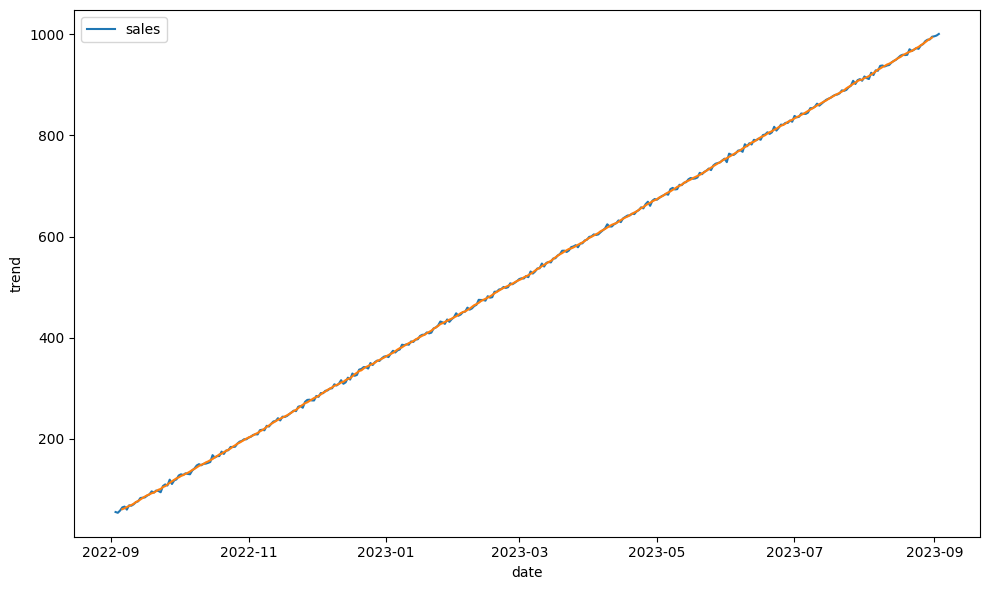

In [11]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 6))

sns.lineplot(data=df)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

In [23]:
df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


Se confirma la tendencia previamente observada y se observa un incremento de las ventas a lo largo del año.

#### Análisis de la estacionalidad

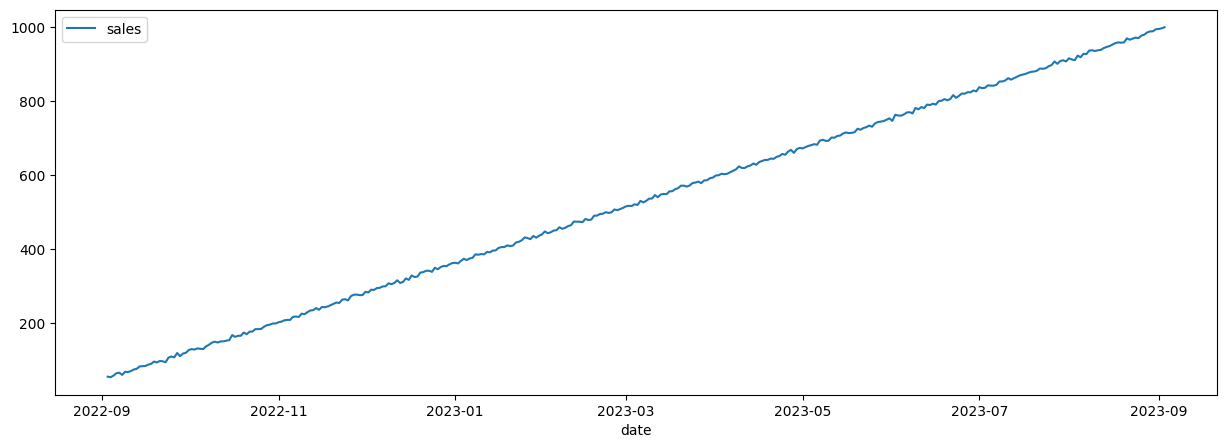

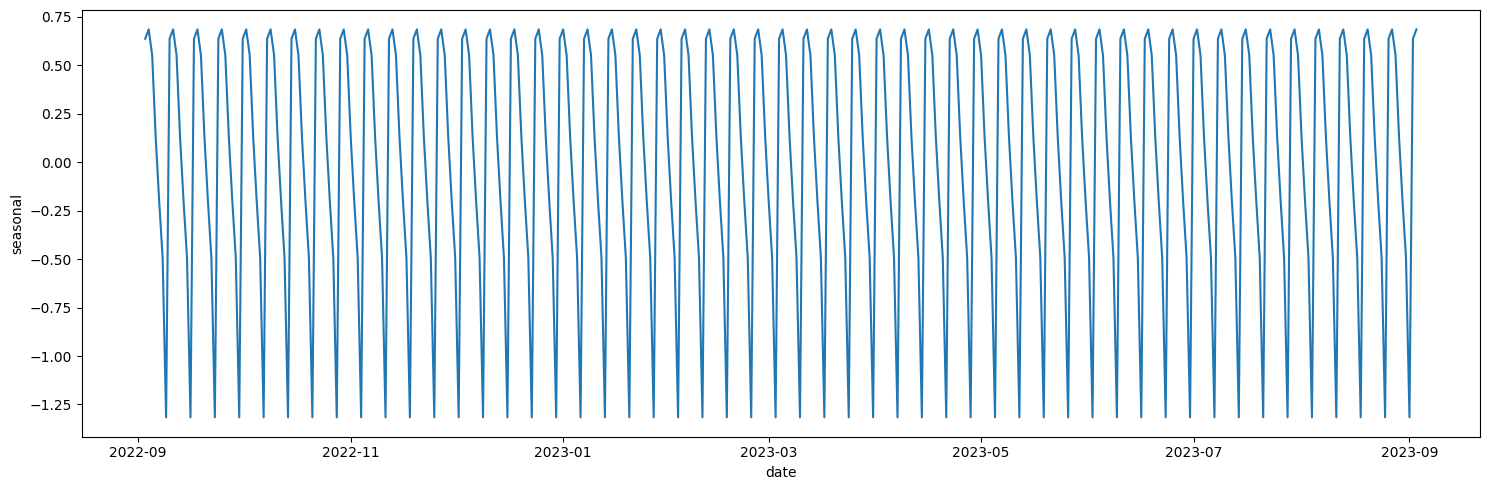

In [14]:
seasonal = decomposition.seasonal

plt.figure(figsize = (15, 5))
sns.lineplot(data = df) 
plt.figure(figsize = (15, 5))
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

De este gráfico observamos una estacionalidad marcada con un patrón que se repite cada 7 días. Sabiendo que el primer regitro del datset es un sábado, se intuye que hay ventas mínimas a principio de semana con un aumento gradual de las ventas que alcanza un pico en fin de semana.

#### Análisis de Estacionariedad

In [24]:
def test_stationarity(timeseries):
    print("Resultados de la prueba Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Resultados de la prueba Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Los resultados del test nos indican que el p-valor es superior a 0.05 por lo que no podemos afirmar con seguridad que la estacionariedad de los datos sea real o debida a la gran tendencia ascendiente que presenta.

In [25]:
# Diferenciar para fijar estacionariedad
df['sales_dif'] = df['sales'].diff()
df.dropna(inplace=True)     #elimina el primer NaN
df

,sales,sales_dif
date,,
2022-09-04,53.803211,-1.488946
2022-09-05,58.141693,4.338482
2022-09-06,64.530899,6.389205
2022-09-07,66.013633,1.482734
2022-09-08,60.081865,-5.931768
...,...,...
2023-08-30,989.600354,0.518681
2023-08-31,994.987326,5.386972
2023-09-01,995.814415,0.827090


In [26]:
test_stationarity(df['sales_dif'])

Resultados de la prueba Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Después de la diferenciación se obtiene un p-valor p-valor 5.21e-16 < 0.05, lo que significa que podemos tomar la serie sales_dif como estacionaria.

#### Análisis de residuos

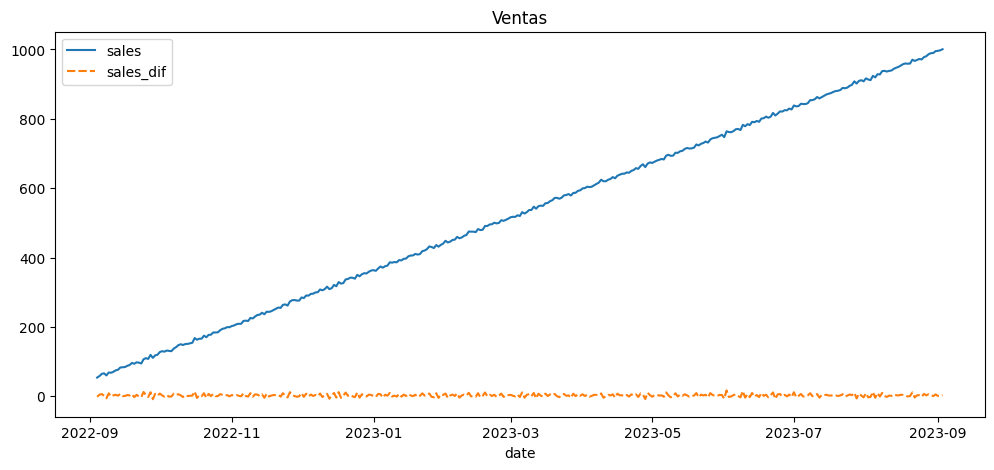

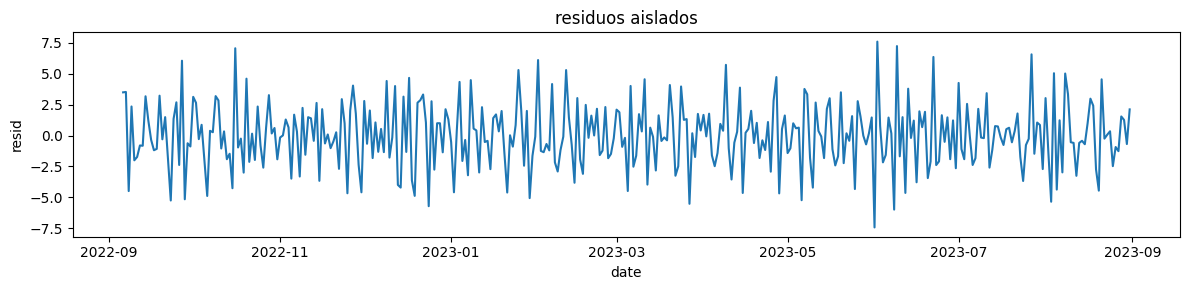

In [29]:
residual = decomposition.resid

plt.figure(figsize = (12, 5))

sns.lineplot(data = df) 
plt.title('Ventas')

plt.figure(figsize = (12, 3))
sns.lineplot(data = residual)
plt.title('residuos aislados')

plt.tight_layout()

plt.show()

De este gráfico se sabe que la descomposición ha sido adecuada y que los residuos se distribuyen al rededor del 0 sin repetir un patrón claro.

### Modelo ARIMA

In [41]:
train_size = int(len(df) * 0.8)

train = df['sales'].iloc[:train_size]
test  = df['sales'].iloc[train_size:]

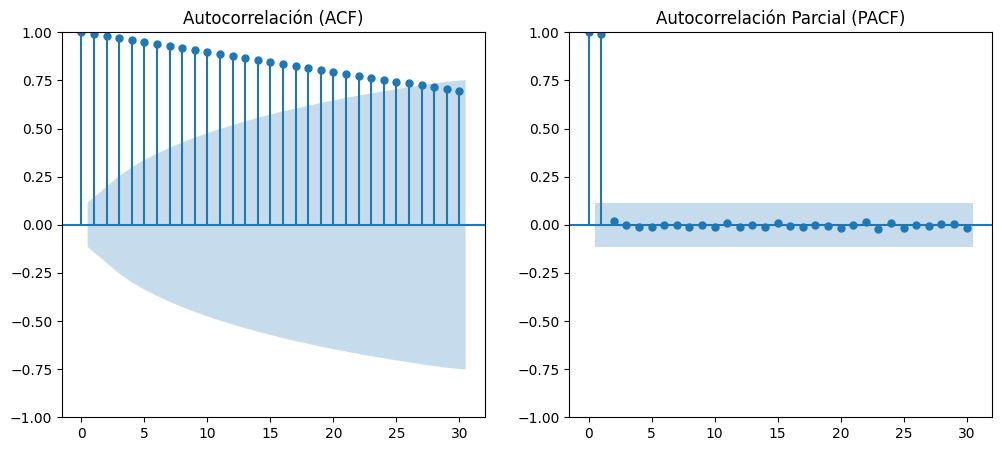

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ACF para determinar q
plot_acf(train, lags=30, ax=ax[0])
ax[0].set_title("Autocorrelación (ACF)")

# PACF para determinar p
plot_pacf(train, lags=30, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()

In [43]:
p = 1
d = 1
q = 1

modelo_arima = ARIMA(train, order=(p,d,q))

modelo_fit = modelo_arima.fit()

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
# Predicciones del conjunto de test
pred = modelo_fit.forecast(steps=len(test))

In [47]:
# Métricas
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 7.235826963334268
RMSE: 7.710557425751433


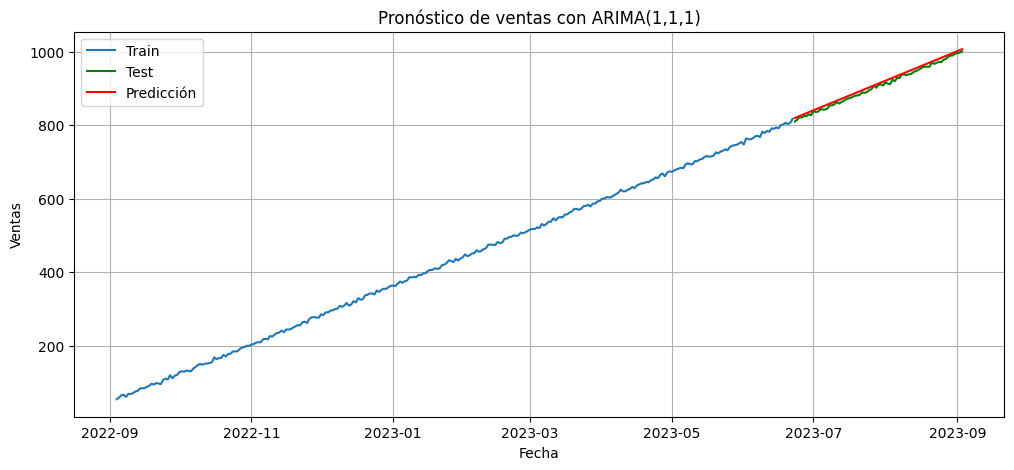

In [49]:
# Graficar pronóstico
plt.figure(figsize=(12,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color = 'green')
plt.plot(pred.index, pred, label='Predicción', color='red')
plt.title("Pronóstico de ventas con ARIMA(1,1,1)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

### Conclusión
El modelo ARIMA(1,1,1) logra seguir la tendencia general de ventas con un error medio de 7.24 unidades, pero suaviza demasiado los picos estacionales.
Se probará el modelo SARIMA para ver si se pueden capturar mejor la estacionalidad perdida.

### SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo_sarima = SARIMAX(
    train,
    order=(1,1,1),          
    seasonal_order=(1,1,1,7) 
)

sarima_fit = modelo_sarima.fit()

# Predicciones test
pred = sarima_fit.predict(start=len(train), end=len(df)-1)

In [51]:
# Métricas
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 2.451508109518906
RMSE: 2.943815434936791


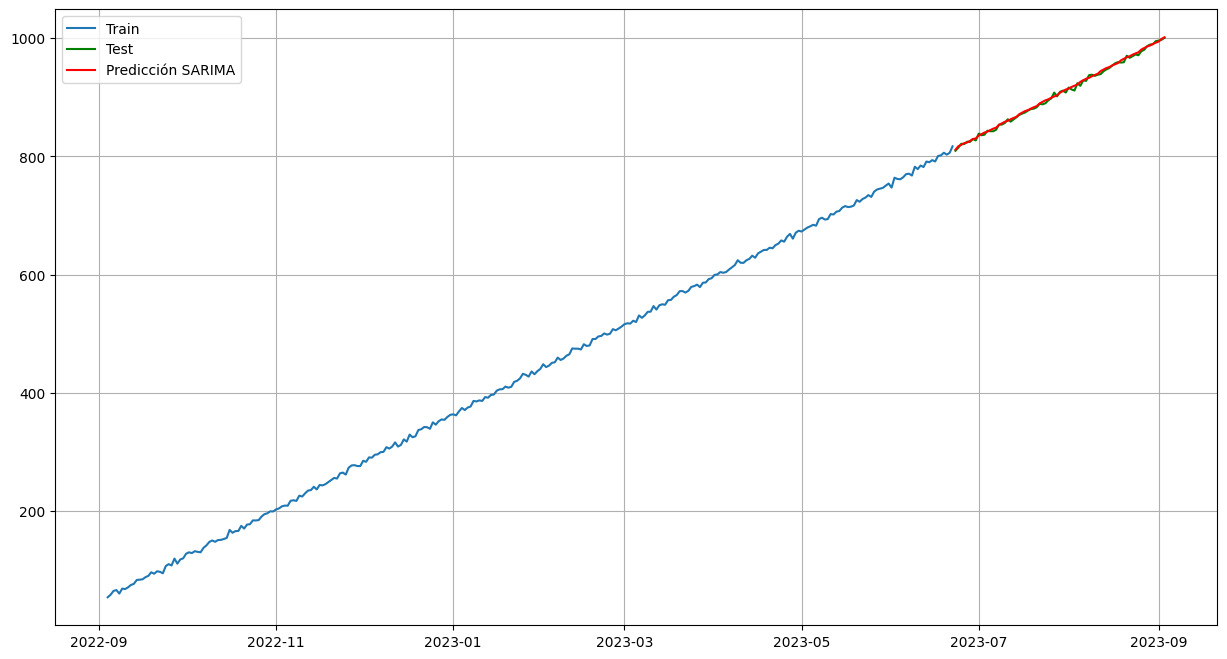

In [52]:
plt.figure(figsize=(15,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color = 'green')
plt.plot(pred, label='Predicción SARIMA', color='red')
plt.legend()
plt.grid(True)
plt.show()

### Conclusión
SARIMA reduce el error de 7.24 a 2.45 de MAE, demostrando que las ventas tienen un fuerte componente estacional. El modelo ahora sigue con mucha más precisión los picos y valles estacionales, capturando los patrones repetitivos que el ARIMA simple no detectaba.

### Guardado del modelo

In [53]:
with open("../models/ARIMA.sav", "wb") as f:
    pickle.dump(modelo_arima, f)

with open("../models/SARIMA.sav", "wb") as f:
    pickle.dump(modelo_sarima, f)